In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.interpolate import griddata
from osgeo import gdal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from scipy.interpolate import Rbf
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import os
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import zscore
from sklearn.inspection import partial_dependence
import numpy as np
import pickle

In [2]:
# Function to read multiple TIFF files and aggregate data
def read_multiple_tiff_data_gdal(file_paths):
    if not isinstance(file_paths, list):
        raise ValueError("file_paths should be a list of file paths.")
    
    all_x, all_y, all_z = [], [], []

    for file_path in file_paths:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"The file {file_path} was not found.")
        
        # Open the dataset
        dataset = gdal.Open(file_path)
        if dataset is None:
            raise RuntimeError(f"Unable to open {file_path}. Please check the file format and contents.")
        
        # Read the data and geotransform
        band = dataset.GetRasterBand(1)
        data = band.ReadAsArray()
        transform = dataset.GetGeoTransform()
        
        # Extract the grid coordinates
        cols = data.shape[1]
        rows = data.shape[0]
        
        x0, dx, _, y0, _, dy = transform
        x = np.linspace(x0, x0 + cols * dx, cols)
        y = np.linspace(y0, y0 + rows * dy, rows)
        
        # Mesh the grid coordinates and flatten them
        x, y = np.meshgrid(x, y)
        all_x.extend(x.flatten())
        all_y.extend(y.flatten())
        all_z.extend(data.flatten())
    
    return np.array(all_x), np.array(all_y), np.array(all_z)

In [3]:
best_params = {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

# D13C STD

In [6]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']


trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site2a_d13c_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site3b_d13c_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site4a_d13c_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site4b_d13c_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site6ab_d13c_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site6c_d13c_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site7_d13c_std_masked.tif' ]

In [5]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)




In [6]:
temperature_z.shape

(11482051,)

In [6]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]


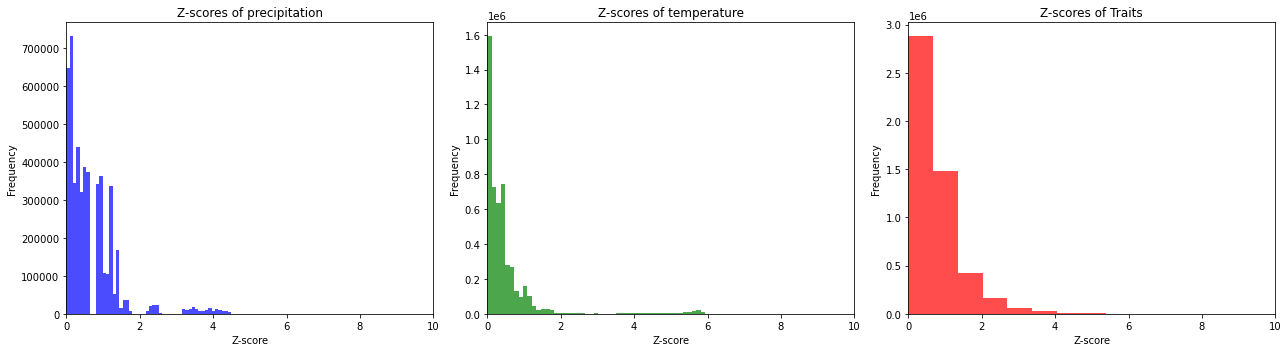

In [7]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'precipitation': filtered_precipitation,
    'temperature': filtered_temperature,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['precipitation'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of precipitation')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['temperature'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of temperature')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [8]:
threshold = 2

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")



Number of rows after outlier removal: 4562176


In [9]:
# Extract the cleaned features and target variable
x_data_clean = data_clean[['precipitation', 'temperature']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

In [11]:

with open(r'E:/wenqu/environmental_factors/3D_Plot/RF_model/d13c_std', 'wb') as f:
    pickle.dump(model, f)


In [7]:
with open(r'E:/wenqu/environmental_factors/3D_Plot/RF_model/d13c_std', 'rb') as f:
    model = pickle.load(f)

In [15]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=1000
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T

# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=300)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='Smoothed Partial Dependence Plot of precipitation vs temperature',
    xlabel='precipitation',
    ylabel='temperature',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

In [8]:
# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=300)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='Smoothed Partial Dependence Plot of precipitation vs temperature',
    xlabel='precipitation',
    ylabel='temperature',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

NameError: name 'Z' is not defined

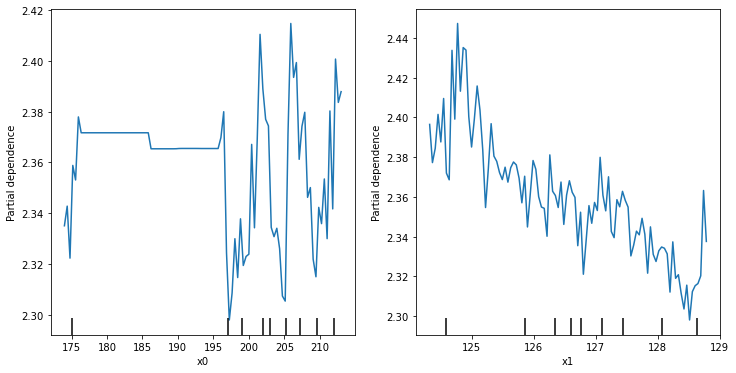

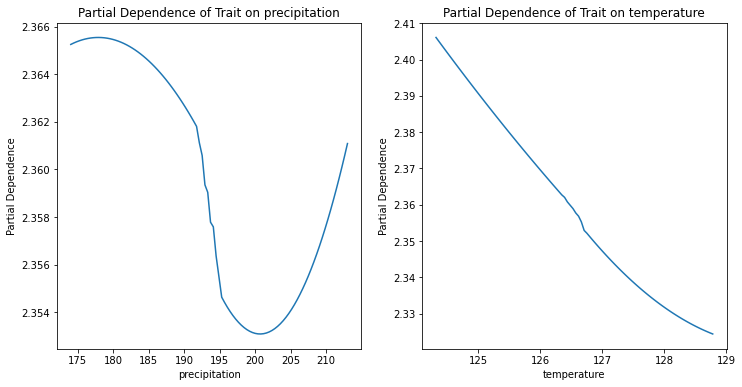

In [23]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=2)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=2)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on precipitation')
ax[0].set_xlabel('precipitation')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on temperature')
ax[1].set_xlabel('temperature')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# D13C YMAX

In [4]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site2a_d13c_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site3b_d13c_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site4a_d13c_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site4b_d13c_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site6ab_d13c_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site6c_d13c_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site7_d13c_ymax_masked.tif' ]

In [5]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)



In [6]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

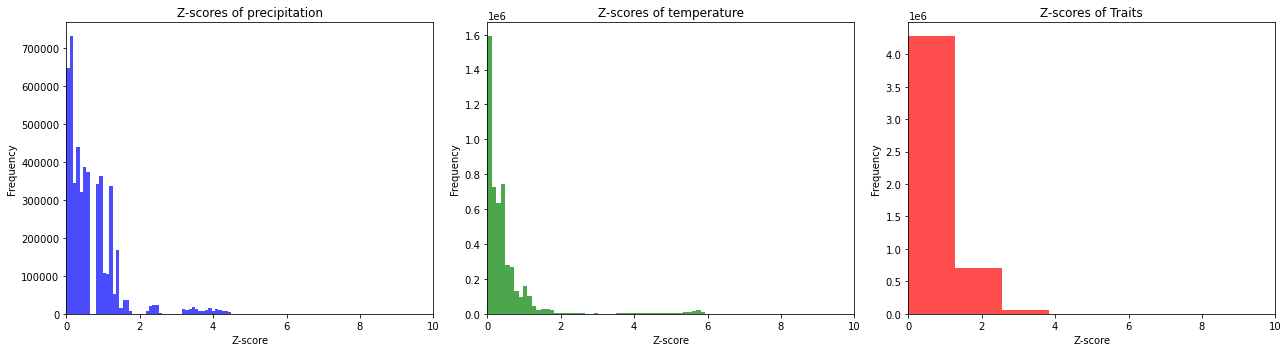

In [7]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'precipitation': filtered_precipitation,
    'temperature': filtered_temperature,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['precipitation'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of precipitation')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['temperature'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of temperature')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [16]:
threshold = 2

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")

# Extract the cleaned features and target variable
x_data_clean = data_clean[['precipitation', 'temperature']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 4645179


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

In [17]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=500
)



C:\Users\laral\Anaconda3\envs\wenqu_gpu\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


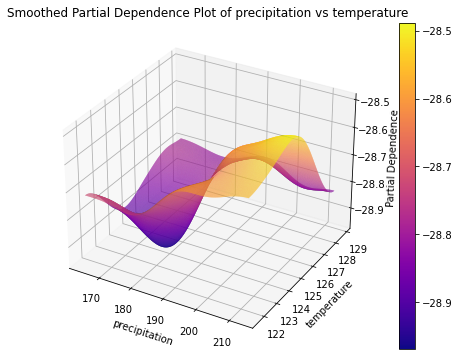

In [18]:
# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T

# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=65)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='Smoothed Partial Dependence Plot of precipitation vs temperature',
    xlabel='precipitation',
    ylabel='temperature',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

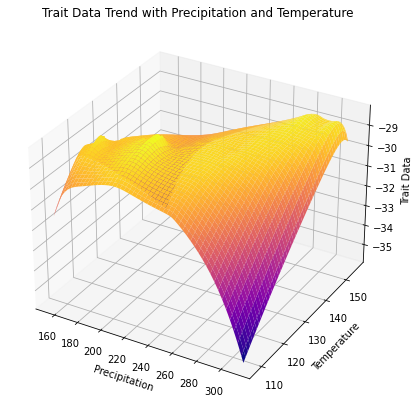

In [14]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


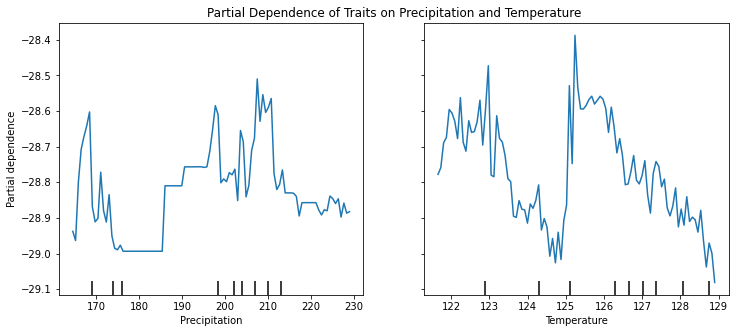

In [15]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features, 
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100, ax=ax)

ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')

plt.show()

# LA ymax

In [16]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site2a_la_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site3b_la_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site4a_la_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site4b_la_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site6ab_la_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site6c_la_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site7_la_ymax_masked.tif' ]

In [17]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [18]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

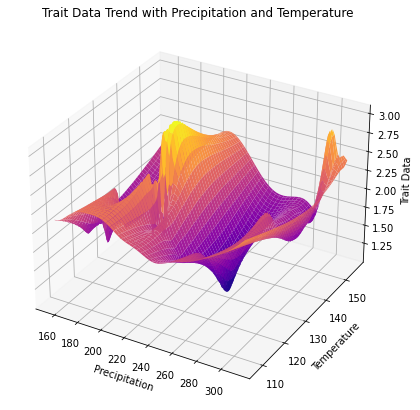

In [19]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


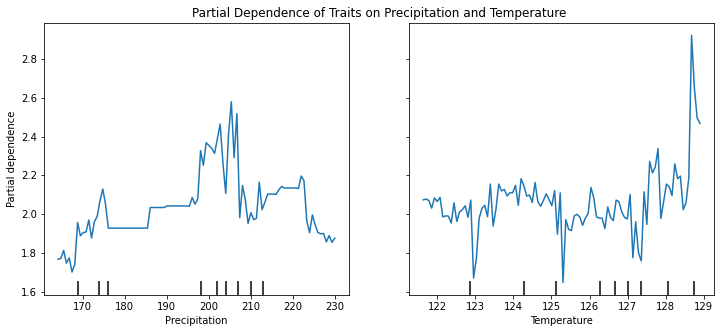

In [20]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# LA std

In [21]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site2a_la_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site3b_la_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site4a_la_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site4b_la_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site6ab_la_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site6c_la_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site7_la_std_masked.tif' ]

In [22]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [23]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

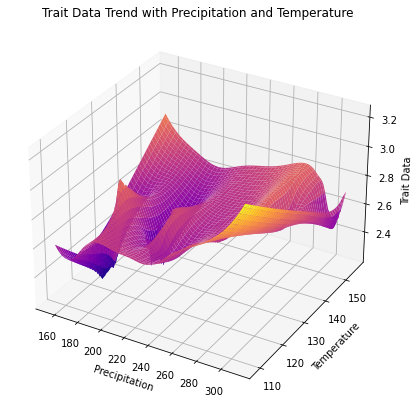

In [24]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


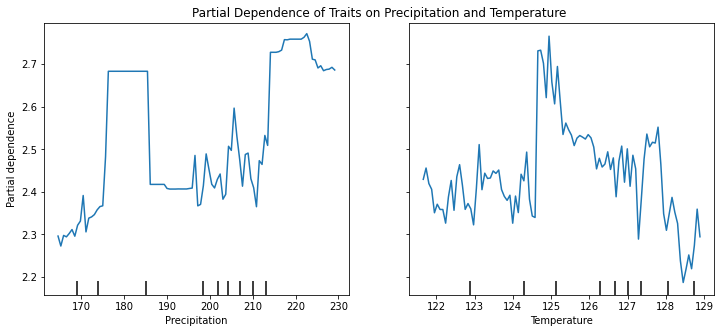

In [25]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# D15n ymax

In [26]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site2a_d15n_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site3b_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site4a_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site4b_d15n_ymax_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site6ab_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site6c_d15n_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site7_d15n_ymax_masked.tif' ]

In [27]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [28]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

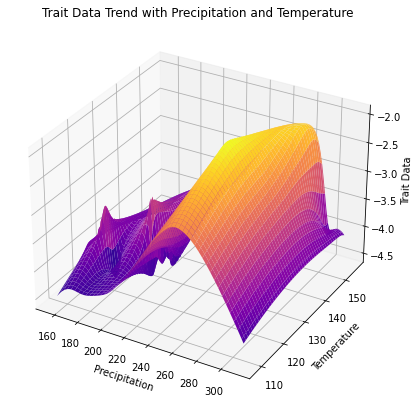

In [29]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=10000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


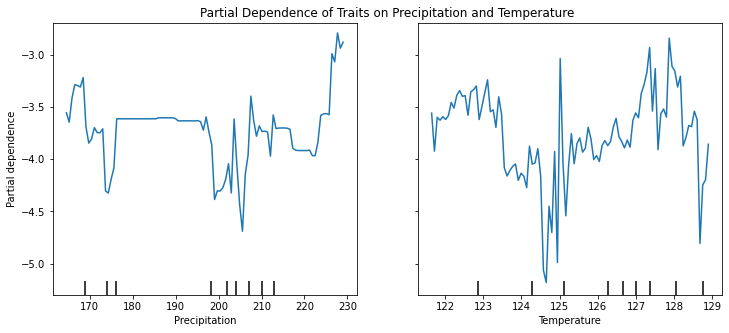

In [30]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# d15n std

In [31]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site2a_d15n_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site3b_d15n_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site4a_d15n_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site4b_d15n_std_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site6ab_d15n_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site6c_d15n_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site7_d15n_std_masked.tif' ]

In [32]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [33]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

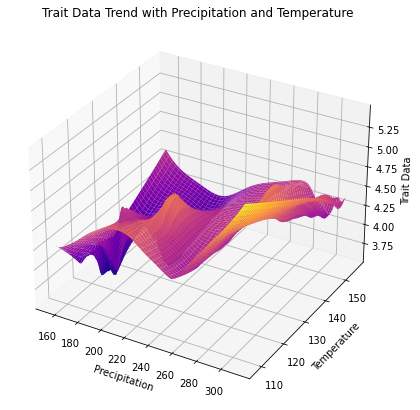

In [34]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


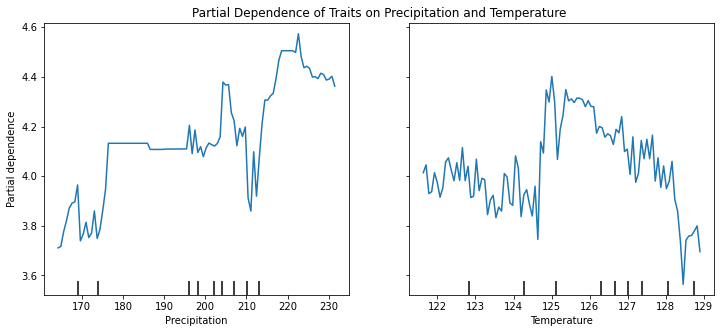

In [35]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# LDMC Ymax

In [36]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site2a_ldmc_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site3b_ldmc_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site4a_ldmc_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site4b_ldmc_ymax_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site6ab_ldmc_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site6c_ldmc_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site7_ldmc_ymax_masked.tif' ]

In [37]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [38]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

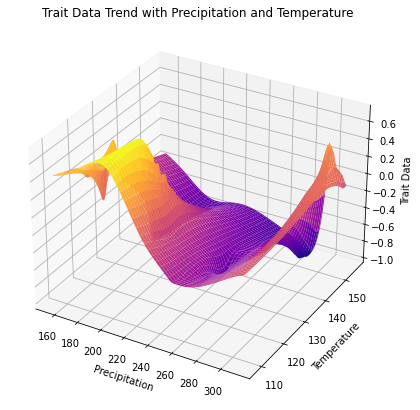

In [39]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


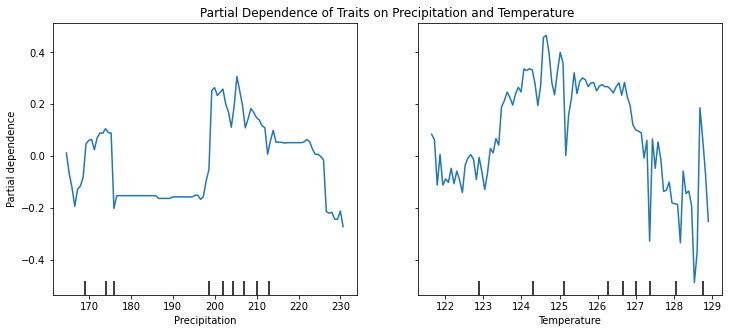

In [40]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# LDMC std

In [41]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site2a_ldmc_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site3b_ldmc_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site4a_ldmc_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site4b_ldmc_std_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site6ab_ldmc_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site6c_ldmc_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site7_ldmc_std_masked.tif' ]

In [42]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [43]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

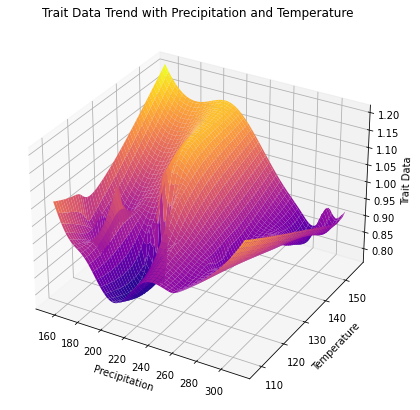

In [44]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


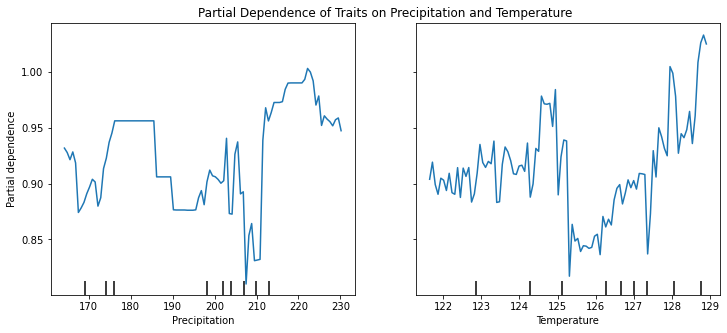

In [45]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# SLA ymax

In [46]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site2a_sla_ymax_mask.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site3b_sla_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site4a_sla_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site4b_sla_ymax_mask.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site6ab_sla_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site6c_sla_ymax_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site7_sla_ymax_mask.tif' ]

In [47]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [48]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

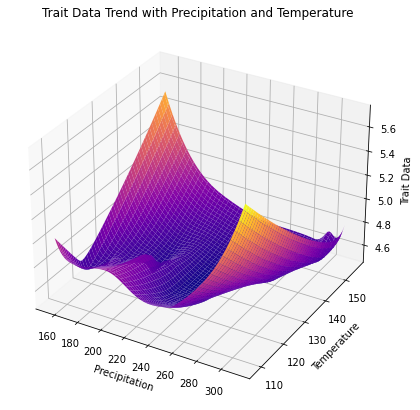

In [49]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


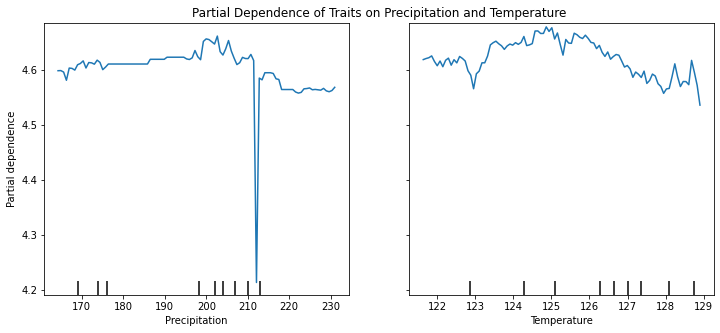

In [50]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# SLA std

In [51]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site2a_sla_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site3b_sla_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site4a_sla_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site4b_sla_std_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site6ab_sla_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site6c_sla_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site7_sla_std_masked.tif' ]

In [52]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [53]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

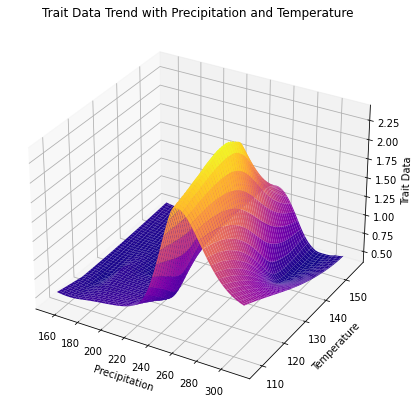

In [54]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


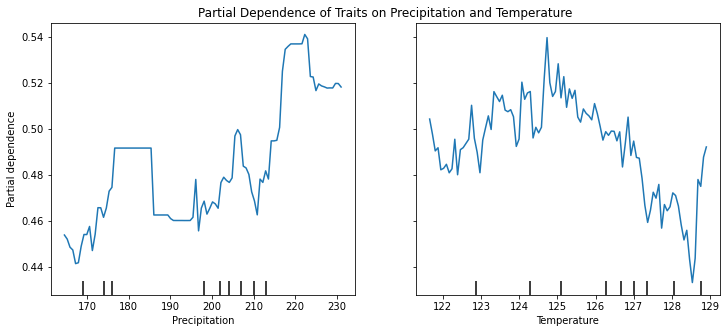

In [55]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# PC ymax

In [56]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_ymax\mask\site2a_pc_ymax_mask.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_ymax\mask\site3b_pc_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_ymax\mask\site4a_pc_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_ymax\mask\site4b_pc_ymax_mask.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_ymax\mask\site6ab_pc_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_ymax\mask\site6c_pc_ymax_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_ymax\mask\site7_pc_ymax_mask.tif' ]

In [57]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [58]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

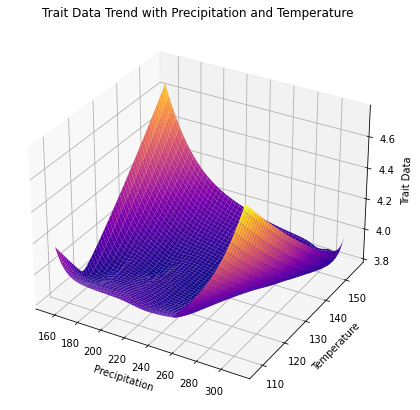

In [59]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


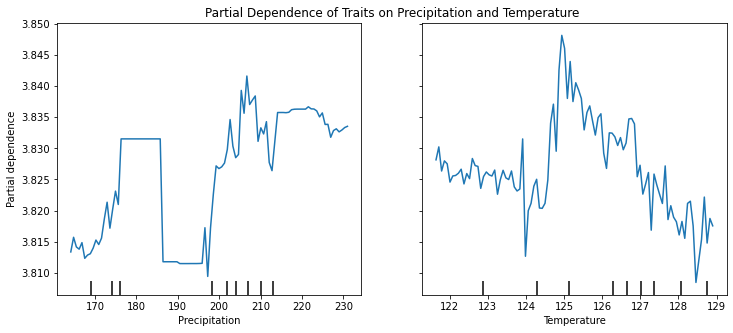

In [60]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# PC std

In [61]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_std\mask\site2a_pc_std_mask.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_std\mask\site3b_pc_std_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_std\mask\site4a_pc_std_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_std\mask\site4b_pc_std_mask.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_std\mask\site6ab_pc_std_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_std\mask\site6c_pc_std_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\pc_std\mask\site7_pc_std_mask.tif' ]

In [62]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [63]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

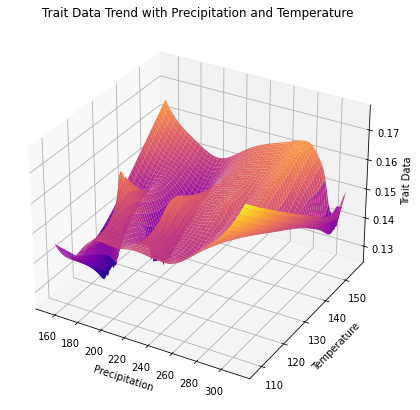

In [64]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


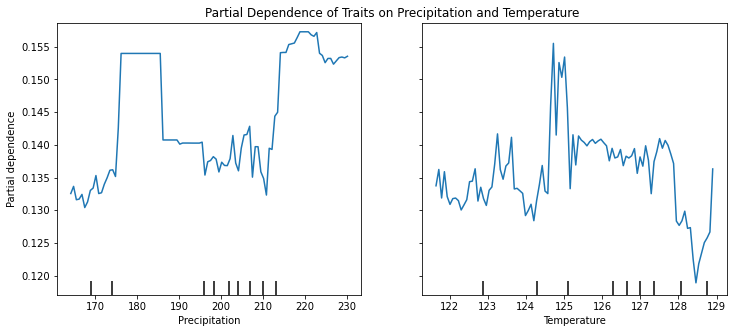

In [65]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()


# d15n ymax -- rad slope


In [66]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']


temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site2a_d15n_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site3b_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site4a_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site4b_d15n_ymax_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site6ab_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site6c_d15n_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site7_d15n_ymax_masked.tif' ]

In [67]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Remove duplicates for each dataset
precipitation_x, precipitation_y, precipitation_z = remove_duplicates(precipitation_x, precipitation_y, precipitation_z)
temperature_x, temperature_y, temperature_z = remove_duplicates(temperature_x, temperature_y, temperature_z)
trait_x, trait_y, trait_z = remove_duplicates(trait_x, trait_y, trait_z)

In [68]:
# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (temperature_z >= 105) & (temperature_z <= 156) 
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]

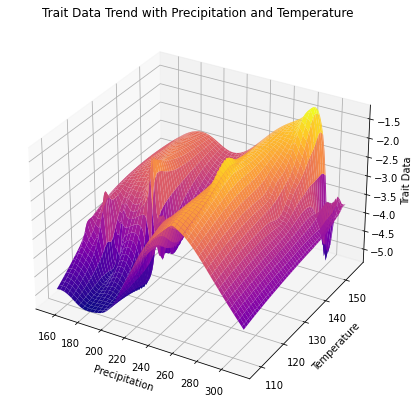

In [69]:
# Example downsampling method to reduce dataset size
def downsample_data(x, y, z, sample_size):
    """Randomly sample a subset of data points."""
    if sample_size < len(x):
        indices = np.random.choice(len(x), sample_size, replace=False)
        return x[indices], y[indices], z[indices]
    return x, y, z




# Convert to float32 and downsample
sample_size = 60000  # Example sample size, adjust as needed
filtered_precipitation, filtered_temperature, filtered_traits = downsample_data(
    filtered_precipitation.astype(np.float32),
    filtered_temperature.astype(np.float32),
    filtered_traits.astype(np.float32),
    sample_size
)


# Create an RBF model using the downsampled data
rbf_traits = Rbf(filtered_precipitation, filtered_temperature, filtered_traits, function='multiquadric', smooth=1000)

# Create a grid for interpolation based on the ranges of downsampled precipitation and temperature values
grid_precipitation, grid_temperature = np.meshgrid(
    np.linspace(min(filtered_precipitation), max(filtered_precipitation), 100),
    np.linspace(min(filtered_temperature), max(filtered_temperature), 100)
)

# Predict trait values using the RBF model
grid_traits = rbf_traits(grid_precipitation, grid_temperature)

# Plot the fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_precipitation, grid_temperature, grid_traits, cmap='plasma')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Temperature')
ax.set_zlabel('Trait Data')
ax.set_title('Trait Data Trend with Precipitation and Temperature')
plt.show()


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the aggregated and filtered data is available as numpy arrays
x_data = np.column_stack((filtered_precipitation, filtered_temperature))
y_data = filtered_traits

# Create and fit a RandomForestRegressor model
rfr = RandomForestRegressor(**best_params)
rfr.fit(x_data, y_data)

# Define the features to investigate
features = [0, 1]  # Precipitation is the 0th feature, Temperature is the 1st

# Plot the partial dependence plots for Precipitation and Temperature
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(rfr, 
                                        x_data, 
                                        features,
                                        feature_names=['Precipitation', 'Temperature'],
                                        kind="average",
                                        grid_resolution=100,
                                        ax=ax)


ax.set_title('Partial Dependence of Traits on Precipitation and Temperature')
plt.show()
